# Identify Paths from BOTTLE proposed route

In [19]:
import sys
import os
CWD = os.path.abspath("")
os.chdir(CWD)
sys.path = ['/home/stef/Tb/pickaxe/'] + sys.path

from minedatabase.pickaxe import Pickaxe
from minedatabase.utils import get_compound_hash
from minedatabase.rules import metacyc_intermediate
from minedatabase.filters import (
    SimilarityFilter,
    SimilaritySamplingFilter,
)

from rdkit.Chem import CanonSmiles

str_dir = "../data/starters_targets_rules/"

input_cpds = str_dir + "3M2O.csv"
target_cpds = str_dir + "aGDM_Target.csv"
rule_list = str_dir + "JN_no_any_no_co2_rules.tsv"
_, coreactant_list, rule_name = metacyc_intermediate(
    # fraction_coverage=1
    n_rules=5
)

In [3]:
pk = Pickaxe(
        coreactant_list=coreactant_list,
        rule_list=rule_list,
        errors=True,
        quiet=True,
        filter_after_final_gen=True,
    )

pk.load_compound_set(compound_file=input_cpds)

pk.load_targets(target_cpds)
tani_filter = True
tani_threshold = [0, 0, 0.3, 0.3, 0.3]
increasing_tani=False

tani_sample = False
sample_size = 10
weight = 5

# Apply filters
if tani_filter:
    taniFilter = SimilarityFilter(
        crit_similarity=tani_threshold, increasing_similarity=increasing_tani
    )
    pk.filters.append(taniFilter)

if tani_sample:
    taniSampleFilter = SimilaritySamplingFilter(
        sample_size=sample_size, weight=weight
    )
    pk.filters.append(taniSampleFilter)
    pass

----------------------------------------
Intializing pickaxe object


RDKit WARNING: [12:17:12] WARNING: not removing hydrogen atom without neighbors
[12:17:12] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [12:17:12] WARNING: not removing hydrogen atom without neighbors
[12:17:12] WARNING: not removing hydrogen atom without neighbors



Done intializing pickaxe object
----------------------------------------

1 compounds loaded...
(1 after removing stereochemistry)
1 target compounds loaded



In [5]:
# Transform compounds (the main step)
processes = 1
generations = 1
pk.transform_all(processes, generations)
pk.prune_network_to_targets()

----------------------------------------
Filtering Generation 0

Applying filter: Similarity Cutoff
Filtering Generation 0 with similarity > 0.
Similarity filter progress: 0 percent complete
Similarity filter progress: 100 percent complete
1 of 1 compounds selected after Similarity filtering of generation 0 at cutoff of 0. --took 0.0s.

Done filtering Generation 0
----------------------------------------

----------------------------------------
Expanding Generation 1

Generation 1: 0 percent complete
Generation 1 finished in 2.3979599475860596 s and contains:
		50 new compounds
		58 new reactions

Done expanding Generation: 1.
----------------------------------------

----------------------------------------
Filtering Generation 1

Applying filter: Similarity Cutoff
Filtering Generation 1 with similarity > 0.
Similarity filter progress: 0 percent complete
Similarity filter progress: 10 percent complete
Similarity filter progress: 20 percent complete
Similarity filter progress: 30 perc

In [6]:
bad_es = []
for i, vals in pk.compounds.items():
    try:
        pk.compounds[i]["SMILES"] = CanonSmiles(vals["SMILES"])
    except BaseException as e:
        bad_es.append(vals["SMILES"])
        pk.compounds[i]["SMILES"] = vals["SMILES"].replace("*", "")
        

In [8]:
os.getcwd()

'/home/stef/Tb/bottle/scripts'

In [9]:
pk.pickle_pickaxe("../data/expansions/4gen_varTanimotoCutoff.pk") # Save results

In [10]:
pk.load_pickled_pickaxe("../data/expansions/4gen_varTanimotoCutoff.pk") # Load results

Loading ../data/expansions/4gen_varTanimotoCutoff.pk pickled data.
Loaded 2558 operators
Loaded 1 targets
Took 1.7630207538604736


# Generate Pathways

In [11]:
from pathway_utils import create_graph_from_pickaxe

# Function to patch older results that weren't made with updated PickaxeGeneric code
def rename_smiles_reaction(pk):
    for rxn in pk.reactions.values():
        rxn["SMILES_rxn"] = rxn["SMILES_reaction"]
        
# Create the initial graph
DG, rxn, edge = create_graph_from_pickaxe(pk, "Biology")
starting_nodes = []
bad_nodes = []
for n in DG.nodes():
    try:
        if DG.nodes()[n]["Type"] == "Starting Compound":
            starting_nodes.append(n)
    except:
        bad_nodes.append(n)

In [12]:
from minedatabase.pickaxe import Pickaxe
from minedatabase import utils

import PIL

from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from pathway_utils import (
    Pathway, count_cpds_and_rxns, get_reverse_paths_to_starting, path_to_generation, create_graph_from_pickaxe, add_nodes_from_pickaxe
)

def get_found_locations(smi):
    isin_list = []
    for key, val in df_stereo_matches.items():
        if smi in val:
            isin_list.append(key)
            
    return isin_list

class Pathways:
    def __init__(self, target_cid, pathways, DG, feas_dict):
        self.target_id = target_cid
        self.pathways = [Pathway(target_cid, pathway, DG, feas_dict) for pathway in pathways]

    @property
    def terminal_generation(self):
        return [pathway.terminal_generation for pathway in self.pathways]
    

rules_to_exclude = ['rule0028_46']
# rules_to_exclude = ['rule0028_51', 'rule0028_46', 'rule0028_50', 'rule0043_12']
rules_to_exclude = ['rule0028_51', 'rule0028_46', 'rule0028_50']
# rules_to_exclude = ['rule0028_50', 'rule0043_12']
# rules_to_exclude = []

def contains_rule(pathway, DG):
    rules = set()
    for keyi in pathway.reaction_stoichs.keys():
        rules_i = DG.nodes()[keyi]["Rule"]
        rules.update(rules_i)

    for rule in rules_to_exclude:
        if rule in rules:
            return True
        
    return False

In [18]:
paths_dict

{}

In [17]:
# Params
max_depth = generations*2
paths_dict = {}

# Fake feas dict
feas_dict = {rxn: True for rxn in [i for i in DG.nodes() if i.startswith("R")]}

# Specify Targets / Starting Cpds
target_smi = pk.target_smiles[0]
target_cids = [get_compound_hash(smi)[0] for smi in pk.target_smiles]
starting_cpds = [get_compound_hash(val["SMILES"])[0] for val in pk.compounds.values() if val["Type"].startswith("Start")]

# Loop through targets and get pathways from targets to starting compounds
for node in target_cids:
    paths = get_reverse_paths_to_starting(DG, begin_node=node, end_nodes=starting_cpds, max_depth=max_depth)
    # If we find paths then reverse those paths and assign to a dictionary
    if paths:
        paths_dict[node] = list(set([tuple(path[1::2]) for path in [[*reversed(ind_path)] for ind_path in paths]]))

target_cid = target_cids[0]
target_paths = [Pathway(target_cid, pathway, DG, feas_dict) for pathway in paths_dict[target_cid]]

pathways = Pathways(target_cid, paths_dict[target_cids[0]], DG, feas_dict)
pathways.pathways = [path for path in pathways.pathways if not (target_smi in path.sources)] # target is starting

len(pathways.pathways)

KeyError: 'Cc2274a1b151121868789bd03eb37b9c4065ef3d1'

In [14]:
n = 0
paths = paths_dict[target_cids[0]][n]

i = 0
while i < len(paths):
    if contains_rule(pathways.pathways[i], DG):
        i += 1
    else:
        ix = i
        rxn_stoichs = pathways.pathways[ix].reaction_stoichs
        # print("Thermo", ix)
        # print("MDF ", pathways.pathways[ix].MDF)
        # print("Sequence ", pathways.pathways[ix].reaction_types)
        # print("Starting", pathways.pathways[ix].sources)
        # print("Sinks", pathways.pathways[ix].sinks)

        reactions = []
        for rxn_stoich in rxn_stoichs.values():
            products = ".".join([".".join([smi]*stoich) for smi, stoich in rxn_stoich.items() if stoich >= 0])
            reactants = ".".join([".".join([smi]*abs(stoich)) for smi, stoich in rxn_stoich.items() if stoich <= 0])

            reaction = ">>".join([reactants, products])
            reactions.append(reaction)

        ri = -1
        i +=1 

        # for keyi in pathways.pathways[ix].reaction_stoichs.keys():
        #     print(keyi, DG.nodes()[keyi])
        
        # print(reactions)
        break

rxn_images = [
    Draw.ReactionToImage(
        AllChem.ReactionFromSmarts(rxn, useSmiles=True),
        subImgSize=(200, 200), useSVG=False, drawOptions=None, returnPNG=False
    ) for rxn in reactions
]

def get_concat_v(im1, im2):
    dst = PIL.Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

# image = rxn_images[0]
# for rxn_image in rxn_images[1:]:
#     image = get_concat_v(image, rxn_image)

# image

KeyError: 'Cc2274a1b151121868789bd03eb37b9c4065ef3d1'

In [15]:
for i in range(len(pathways.pathways)):
    if contains_rule(pathways.pathways[i], DG):
        print('bad rule')

NameError: name 'pathways' is not defined

In [224]:
i=0

0
0
1
R80a7a110576dd9b716c5ac27e08710b427f778bf2f6763c2eeec68924b302f00 {'bipartite': 1, 'Rule': {'rule0043_12'}, 'Type': 'Biology', 'Stoich': {'CC(C)C(=O)O': -1, 'C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O': -1, 'CC(C)(C)C(=O)O': 1, 'Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O': 1}, 'feasible': None, 'Reactants': [(1, 'C2d94449d2035580e3a2de661386c29c111c7bf71'), (1, 'X9b5ec04e3e13766613e65d29e9d5b275fd8a0317')], 'Products': [(1, 'Xca3125292d42b5595b65696d5cd74e007b886297'), (1, 'C743d3d3a4a0e2cf0e31d4d7623c0d79884571a95')]}
Ra70122a22903bfb5cde4f132c01565531ee96e8a1ae6a48b48526025b265eba6 {'bipartite': 1, 'Rule': {'rule0028_47'}, 'Type': 'Biology', 'Stoich': {'CC(C)(C)C(=O)O': -1, 'CCC(C)C(=O)O': 1}, 'feasible': None, 'Reactants': [(1, 'C743d3d3a4a0e2cf0e31d4d7623c0d79884571a95')], 'Products': [(1, 'Cf30f602c179c10791dd924abb7522ea6a08a3e38')]}
R3979793aba19327737f15d29e02daf6ccc555a0b9fbe6caabecb063d9b9cb6e3 {'bipartite': 1, 'Rule': {'rule0004_13'}, 'Type': 'Biology', 'Stoich':

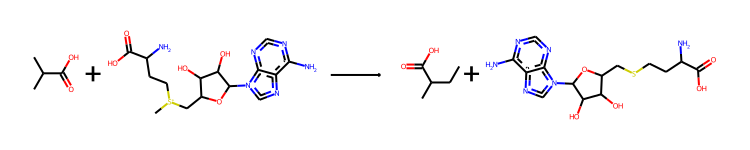

In [225]:
paths = paths_dict[target_cids[0]][i]

print(i)
rxn_stoichs = pathways.pathways[i].reaction_stoichs

while contains_rule(pathways.pathways[i], DG):
    print(i)
    i += 1

reactions = []
for rxn_stoich in rxn_stoichs.values():
    products = ".".join([".".join([smi]*stoich) for smi, stoich in rxn_stoich.items() if stoich >= 0])
    reactants = ".".join([".".join([smi]*abs(stoich)) for smi, stoich in rxn_stoich.items() if stoich <= 0])

    reaction = ">>".join([reactants, products])
    reactions.append(reaction)

for keyi in pathways.pathways[i].reaction_stoichs.keys():
    print(keyi, DG.nodes()[keyi])
i += 1
AllChem.ReactionFromSmarts(reactions[0], useSmiles=True)

In [181]:
pathways.pathways[i].reaction_stoichs.keys()

dict_keys(['R74a3f70f512dde5e737dfa621ead298df33f4aa26aea939c9ecc4dfb128c9f68', 'R24252f82a12e82069b6535927b57cbaf5aaa42fee7cb3b71dac8f227158139ec', 'R3e245f44bd85be5c51db4198cc4f8886feacef2d4467c21e8590e252f3c882c4', 'Rfa06fdf1de128b497279c2e28639d50e249dd2ba1d6190519fd8cc4ad00c2e1d'])

In [ ]:
# AllChem.ReactionFromSmarts(reactions[0], useSmiles=True)


['CC(C)C(=O)O.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1.O=O>>CC(CO)C(=O)O.NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1.O',
 'CC(CO)C(=O)O.C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O>>CCC(CO)C(=O)O.Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O',
 'CCC(CO)C(=O)O.C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O>>CCC(C(=O)O)C(C)O.Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O',
 'CCC(C(=O)O)C(C)O>>CC(O)C(C)(C)C(=O)O']

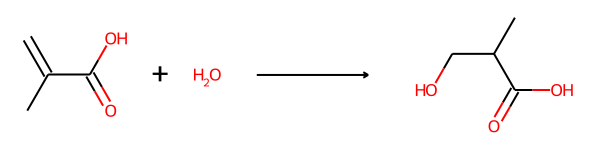

In [220]:
AllChem.ReactionFromSmarts(reactions[1], useSmiles=True)

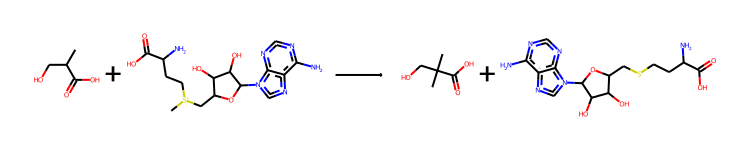

In [221]:
AllChem.ReactionFromSmarts(reactions[2], useSmiles=True)

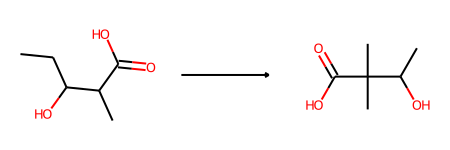

In [226]:
AllChem.ReactionFromSmarts(reactions[3], useSmiles=True)

In [227]:
pathways.pathways[i].reaction_stoichs

{'R358edd8a2462616027177ee26c19038e9fcf58ca955e5e8472e4ca848b161382': {'CC(C)C(=O)O': -1,
  'C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O': -1,
  'CCC(C)C(=O)O': 1,
  'Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O': 1},
 'Rec9263a95cfb3eefd6b3eec58e67b4003ffa2a1afd079813be59d88e479cbd91': {'CCC(C)C(=O)O': -1,
  'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': -1,
  'O=O': -1,
  'CC(CCO)C(=O)O': 1,
  'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': 1,
  'O': 1},
 'R4a2c2df616bf734244fb7c5e35b1db89933ce2bea43df9a61a7bb80160a20652': {'CC(CCO)C(=O)O': -1,
  'C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O': -1,
  'CC(O)CC(C)C(=O)O': 1,
  'Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O': 1},
 'R44352c9652a32680f0d9896c161aa95cbc7795202933f1f4489d3ea16372b54e': {'CC(O)CC(C)C(=O)O': -1,
  'CC(O)C(C)(C)C(=O)O': 1}}